# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
%%!
pip install --trusted-host pypi.org ipython-sql

['Requirement already satisfied: ipython-sql in /anaconda3/lib/python3.7/site-packages (0.3.9)',
 'Requirement already satisfied: sqlalchemy>=0.6.7 in /anaconda3/lib/python3.7/site-packages (from ipython-sql) (1.2.11)',
 'Requirement already satisfied: six in /anaconda3/lib/python3.7/site-packages (from ipython-sql) (1.11.0)',
 'Requirement already satisfied: sqlparse in /anaconda3/lib/python3.7/site-packages (from ipython-sql) (0.3.0)',
 'Requirement already satisfied: ipython-genutils>=0.1.0 in /anaconda3/lib/python3.7/site-packages (from ipython-sql) (0.2.0)',
 'Requirement already satisfied: prettytable in /anaconda3/lib/python3.7/site-packages (from ipython-sql) (0.7.2)',
 'Requirement already satisfied: ipython>=1.0 in /anaconda3/lib/python3.7/site-packages (from ipython-sql) (6.5.0)',
 'Requirement already satisfied: pygments in /anaconda3/lib/python3.7/site-packages (from ipython>=1.0->ipython-sql) (2.2.0)',
 'Requirement already satisfied: jedi>=0.10 in /anaconda3/lib/python3.

In [2]:
%load_ext sql

In [3]:
%sql sqlite://

'Connected: @None'

In [4]:
%%sql
create table pslv(ID int, Name varchar(10));
insert into pslv values(1, 'A');
select * from pslv;

 * sqlite://
Done.
1 rows affected.
Done.


ID,Name
1,A


In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [6]:
con = sqlite3.connect('/Users/nilesh/Downloads/Test_Dataset/amazon-fine-food-reviews/database.sqlite') 
amz_all_data = pd.read_sql_query("select * from Reviews", con)
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews where score != 3""", con) 

KeyboardInterrupt: 

In [ ]:
amz_all_data.head()

In [ ]:
#This is complete data:
amz_all_data.count()

In [ ]:
filtered_data.count()

In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""SELECT * FROM Reviews 
where score != 3 and UserId="AR5J8UI46CURR" ORDER BY ProductID
""", con)
#print(display)
display.head(3)

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, 
ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId",
            "ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

# [4.3] Overview of the data


In [ ]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
data = pd.read_json('/Users/nilesh/Downloads/Data Science/Test_Dataset/tops_fashion.json')
data.shape

In [ ]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

In [ ]:
# each product/item has 19 features in the raw dataset.
data.columns # prints column-names or feature-names.

In [ ]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 
             'product_type_name', 'title', 'formatted_price']]

In [ ]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

In [ ]:
# We have total 72 unique type of product_type_names
print(data['product_type_name'].describe())

# 91.62% (167794/183138) of the products are shirts,


In [ ]:
# names of different product types
print(data['product_type_name'].unique())

In [ ]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

In [ ]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

In [ ]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

In [ ]:

print(data['color'].describe())


# we have 7380 unique colors
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. That's approx 35.4%.

In [ ]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

In [ ]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

In [ ]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

In [ ]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this workshop 
# as they are short and informative.


In [ ]:
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

In [ ]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])


In [ ]:
data.to_pickle('/Users/nilesh/28k_apparel_data')

# Taxi demand prediction in New York City

In [7]:
import dask.dataframe as dd
import pandas as pd
import folium
import datetime
import time
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
import gpxpy.geo

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.7/site-packages/t

In [8]:
!pip install folium

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
!pip install gpxpy

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Data Information

<p> Get the data from : http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml (2016 data)
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) 
</p>

# Information on taxis:

<h5> Yellow Taxi: Yellow Medallion Taxicabs</h5>
<p> These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.</p>

<h5> For Hire Vehicles (FHVs) </h5>
<p> FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged. </p>

<h5> Green Taxi: Street Hail Livery (SHL) </h5>
<p>  The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides. </p>
<p> Credits: Quora</p>

<h5>Footnote:</h5>
In the given notebook we are considering only the yellow taxis for the time period between Jan - Mar 2015 & Jan - Mar 2016

# Data Collection
We Have collected all yellow taxi trips data from jan-2015 to dec-2016(Will be using only 2015 data)
<table>
<tr>
<th> file name </th>
<th> file name size</th>
<th> number of records </th>
<th> number of features </th>
</tr>
<tr>
<td> yellow_tripdata_2016-01 </td>
<td> 1. 59G </td>
<td> 10906858 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-02 </td>
<td> 1. 66G </td>
<td> 11382049 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-03 </td>
<td> 1. 78G </td>
<td> 12210952 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-04 </td>
<td> 1. 74G </td>
<td> 11934338 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-05 </td>
<td> 1. 73G </td>
<td> 11836853 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-06 </td>
<td> 1. 62G </td>
<td> 11135470 </td>
<td> 19 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-07 </td>
<td> 884Mb </td>
<td> 10294080 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-08 </td>
<td> 854Mb </td>
<td> 9942263 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-09 </td>
<td> 870Mb </td>
<td> 10116018 </td>
<td> 17 </td>
</tr>

<tr>
<td> yellow_tripdata_2016-10 </td>
<td> 933Mb </td>
<td> 10854626 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-11 </td>
<td> 868Mb </td>
<td> 10102128 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2016-12 </td>
<td> 897Mb </td>
<td> 10449408 </td>
<td> 17 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-01 </td>
<td> 1.84Gb </td>
<td> 12748986 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-02 </td>
<td> 1.81Gb </td>
<td> 12450521 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-03 </td>
<td> 1.94Gb </td>
<td> 13351609 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-04 </td>
<td> 1.90Gb </td>
<td> 13071789 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-05 </td>
<td> 1.91Gb </td>
<td> 13158262 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-06 </td>
<td> 1.79Gb </td>
<td> 12324935 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-07 </td>
<td> 1.68Gb </td>
<td> 11562783 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-08 </td>
<td> 1.62Gb </td>
<td> 11130304 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-09 </td>
<td> 1.63Gb </td>
<td> 11225063 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-10 </td>
<td> 1.79Gb </td>
<td> 12315488 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-11 </td>
<td> 1.65Gb </td>
<td> 11312676 </td>
<td> 19 </td>
</tr>
<tr>
<td> yellow_tripdata_2015-12 </td>
<td> 1.67Gb </td>
<td> 11460573 </td>
<td> 19 </td>
</tr>
</table>

In [10]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
month = dd.read_csv('/Users/nilesh/Downloads/Test_Dataset/yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [11]:
#table below shows few datapoints along with all our features
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


# 1. Pickup Latitude and Pickup Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [12]:
# Plotting pickup cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.pickup_longitude <= -74.15) | 
                           (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | 
                           (month.pickup_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:4347: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 8003 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


<b>Observation:-</b> As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada

### 2. Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with dropoffs which are within New York.

In [13]:
# Plotting dropoff cordinates which are outside the bounding box of New-York 
# we will collect all the points outside the bounding box of newyork city to outlier_locations
outlier_locations = month[((month.dropoff_longitude <= -74.15) | 
                           (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | 
                           (month.dropoff_latitude >= 40.9176))]

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

# note: you dont need to remember any of these, you dont need indeepth knowledge on these maps and plots

map_osm = folium.Map(location=[40.734695, -73.990372], 
                     tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:4347: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 8591 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


<b>Observation:-</b> The observations here are similar to those obtained while analysing pickup latitude and longitude

# 3. Trip Durations:

# <p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [1]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert this string into python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
                       .timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration
                       ['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration
                     ['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))
    /float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance',
                       'pickup_longitude','pickup_latitude',
                       'dropoff_longitude','dropoff_latitude',
                       'total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']
                             /new_frame['trip_times'])
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(month)

NameError: name 'month' is not defined

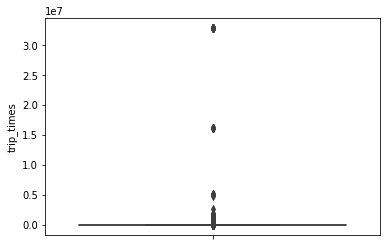

In [15]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [16]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -72661.0
10 percentile value is 230.0
20 percentile value is 323.0
30 percentile value is 409.0
40 percentile value is 498.0
50 percentile value is 597.0
60 percentile value is 712.0
70 percentile value is 857.0
80 percentile value is 1058.0
90 percentile value is 1407.0
100 percentile value is  32913338.0


In [17]:
#looking further from the 99th percecntile
for i in range(60,70):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("70 percentile value is ",var[-1])

60 percentile value is 712.0
61 percentile value is 725.0
62 percentile value is 738.0
63 percentile value is 752.0
64 percentile value is 765.0
65 percentile value is 780.0
66 percentile value is 794.0
67 percentile value is 809.0
68 percentile value is 825.0
69 percentile value is 840.0
70 percentile value is  32913338.0


In [18]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(60+i,var[int(len(var)*(float(60+i)/100))]))
print("100 percentile value is ",var[-1])

60.0 percentile value is 712.0
60.1 percentile value is 713.0
60.2 percentile value is 715.0
60.3 percentile value is 716.0
60.4 percentile value is 717.0
60.5 percentile value is 719.0
60.6 percentile value is 720.0
60.7 percentile value is 721.0
60.8 percentile value is 722.0
60.9 percentile value is 724.0
100 percentile value is  32913338.0


In [19]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

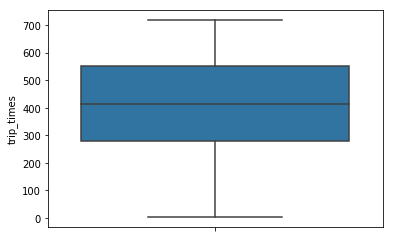

In [20]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


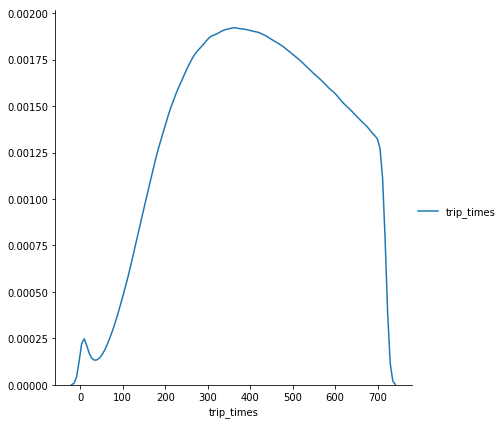

In [21]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [22]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


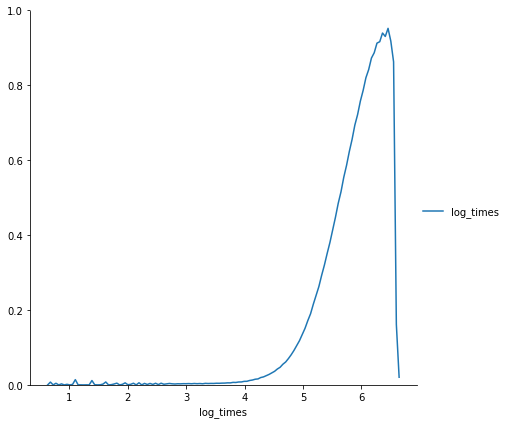

In [23]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

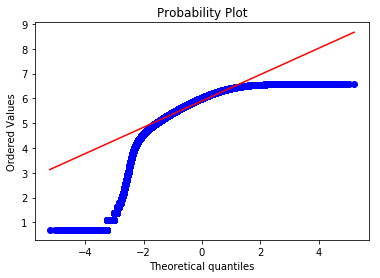

In [24]:
import scipy
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

# 4. Speed

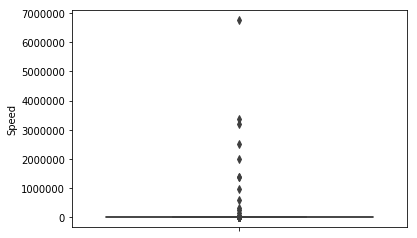

In [27]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [28]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.10846905537459285
20 percentile value is 0.13076923076923075
30 percentile value is 0.14796747967479676
40 percentile value is 0.16363636363636364
50 percentile value is 0.17941176470588235
60 percentile value is 0.19642857142857142
70 percentile value is 0.21649484536082472
80 percentile value is 0.24324324324324326
90 percentile value is 0.2884615384615385
100 percentile value is  6770939.571428571


In [29]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 0.2884615384615385
91 percentile value is 0.2953846153846154
92 percentile value is 0.30324909747292417
93 percentile value is 0.3121951219512195
94 percentile value is 0.32264150943396225
95 percentile value is 0.3351063829787234
96 percentile value is 0.3506172839506173
97 percentile value is 0.371
98 percentile value is 0.4
99 percentile value is 0.45333333333333337
100 percentile value is  6770939.571428571


In [30]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 0.45333333333333337
99.1 percentile value is 0.46153846153846156
99.2 percentile value is 0.4719101123595505
99.3 percentile value is 0.483495145631068
99.4 percentile value is 0.49740932642487046
99.5 percentile value is 0.5154302670623145
99.6 percentile value is 0.5394736842105263
99.7 percentile value is 0.575
99.8 percentile value is 0.636986301369863
99.9 percentile value is 1.7999999999999998
100 percentile value is  6770939.571428571


In [31]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<57.5)]

In [32]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

0.21553697124155544

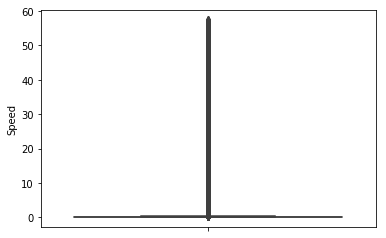

In [35]:
#box-plot after removal of outliers
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

<b style='font-size:16px'>The avg speed in Newyork is 21.55miles/hr, so a cab driver can travel <font color='blue'> 3.55 miles per 10min on avg.</font> </b>

# 4. Trip Distance

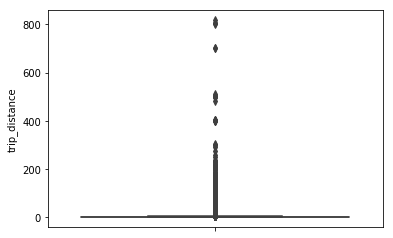

In [36]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [37]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.7
60 percentile value is 2.08
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 6.0
100 percentile value is  818.6


In [38]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.0
91 percentile value is 6.5
92 percentile value is 7.1
93 percentile value is 7.9
94 percentile value is 8.8
95 percentile value is 9.7
96 percentile value is 10.7
97 percentile value is 12.3
98 percentile value is 16.29
99 percentile value is 18.23
100 percentile value is  818.6


In [39]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.23
99.1 percentile value is 18.44
99.2 percentile value is 18.69
99.3 percentile value is 18.93
99.4 percentile value is 19.24
99.5 percentile value is 19.6
99.6 percentile value is 20.1
99.7 percentile value is 20.68
99.8 percentile value is 21.4
99.9 percentile value is 23.1
100 percentile value is  818.6


In [40]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23.1)]

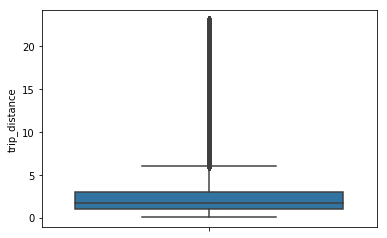

In [41]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

# 5. Total Fare

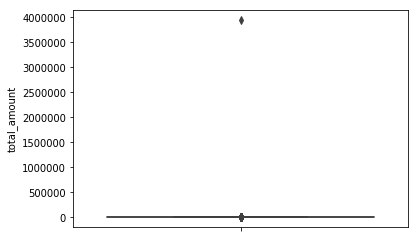

In [42]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [43]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [44]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.84
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [45]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.6
99.8 percentile value is 75.47
99.9 percentile value is 88.3
100 percentile value is  3950611.6


<b>Observation:-</b> As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

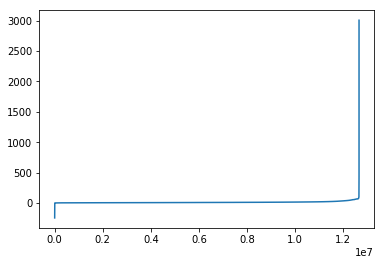

In [46]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

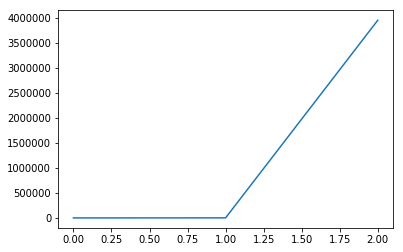

In [47]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

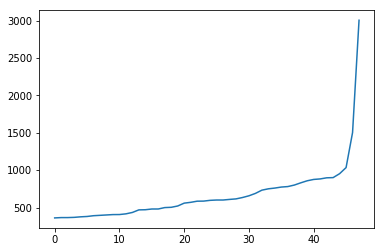

In [48]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()